In [10]:
#Standard packages for data analysis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#stats packages
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import poisson


# Step 1: Data Wrangling

Our first step is to retrieve the all the necessary historical football results which will be used to calibrate 
the parameters in our model. We use "http://www.football-data.co.uk" as our source for match results 
(this is due to the availability of match results in 'csv' format on this website).

We import the entire set of match results for every season of the Premier League since its inception for this project.
We also import the football results for the division directly below the Premier League known 
as 'The Championship' (i.e the second tier within the english football league system) for 
the same time period which will also be used in the parameter calibration process.

We create some functions below that efficiently get our data ready for use. Note that the code pertaining to this section
will take approximately 2 mins to run.

In [11]:
def get_seasons(start_year,end_year):
    """
    Creates a list of unique strings to represent every season in our data set. A season takes place during two calendar years
    so we use both years to identify a particular season. We use the last two digits of the first calendar year followed by 
    the last two digits of the second calendar year (separated with a hyphen -) to represent a season. This a string variable.
    
    e.g get_seasons(2003,2006) will return [03-04,04-05,05-06]
        
    Args:
        start_year (int): The year which the first season started
        end_year (int): The year when the last season ended

    Returns:
        list: a list of unique strings representing every season between the start year and end year
    """

    seasons=[]
    for y in range(start_year,end_year):
        #last two digits in year 1, last two digits in year 2
        seasons.append(str(y)[-2:]+'-'+str(y+1)[-2:])
    return seasons


def retrieve_historic_season_data(season,division):
    """ 
    This function retrieves the full set of historic match results for a given season for a
    specified division by accessing the appropriate variable URL
    
    Args:
        season (string): season using the defined string format e.g select '04-05' for 2004-05 season
        division (string): 'epl' corresponds to Premier League while 'champ' corresponds to the Championship

    Returns:
        dataframe: a dataframe of match results for one specified season
    """
    
    #necessary data is only in the first 7 columns
    #URL is variable with season
    if division=='epl':
        data = pd.read_csv("http://www.football-data.co.uk/mmz4281/"+str(season).replace("-", "", 1)+"/E0.csv",sep=",",
                           usecols=[0,1,2,3,4,5,6,7])
    if division=='champ':
        data = pd.read_csv("http://www.football-data.co.uk/mmz4281/"+str(season).replace("-", "", 1)+"/E1.csv",sep=",",
                           usecols=[0,1,2,3,4,5,6,7])
    
    #keep only hometeam, awayteam, homegoals and awaygoals in dataframe
    data =  data[['HomeTeam','AwayTeam','FTHG','FTAG']]
    
    #rename columns for ease
    data =  data.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
    
    #remove NA
    data=data.dropna()
    
    return data


def store_football_results(season_list,division):
    """ 
    stores the match results for every season for the specified division in a dictionary. The keys to access the values in
    the dictionary are in the following string format: division+season. E.g 'epl20-21' will access the results for 
    2020-21 Premier League
        
    Args:
        season_list: list of seasons (in defined string format)
        division: 'epl' corresponds to Premier League while 'champ' corresponds to the Championship

    Returns:
        dictionary: values are dataframes of season match results
                    keys are in the form division+season e.g 'epl20-21' for 2020-21 Premier League
    """
    
    #initialise blank lists for the keys and the values for dict
    data_values=[]
    data_keys=[]
    
    #loop through every season to retrieve match results and append
    for season in season_list:
        data_values.append(retrieve_historic_season_data(season,division))
        data_keys.append(str(division+season))
        
    #create a dictionary with two lists
    data_dict=dict(zip(data_keys,data_values))
    
    return data_dict

In [12]:
# Period of interest is between 1993-2021 so get all seasons during this time and put into a list.
season_hist= get_seasons(1993,2021)

# only two divisions we need - put into a list
division_list=['epl','champ']

# Store all the football results (EPL and Championship) in one dictionary
football_results={**store_football_results(season_hist, division_list[0]),**store_football_results(season_hist,division_list[1])}


In [13]:
#Full set of match results for the 2006-07 Championship season
# adjust if necessary to view other season/division results
football_results['champ06-07']


,HomeTeam,AwayTeam,HomeGoals,AwayGoals
0,Barnsley,Cardiff,1,2
1,Birmingham,Colchester,2,1
2,Burnley,QPR,2,0
3,Ipswich,Crystal Palace,1,2
4,Leeds,Norwich,1,0
...,...,...,...,...
547,Preston,Birmingham,1,0
548,QPR,Stoke,1,1
549,Sheffield Weds,Norwich,3,2
550,Southampton,Southend,4,1


 We create a function to produce the historic final league table based on a historic set of season's results. Unfortunately, there is no nice
API to get this data so we have to build the historic final league tables from scratch. We need historic league tables to calibrate the parameters.


In [14]:
def get_historic_league_table(season,division):
    """ 
    creates the historic final league table for a given season and division
        
    Args:
        season (string): season in defined format
        division (string): 'epl' corresponds to Premier League while 'champ' corresponds to the Championship

    Returns:
        dataframe: final league table
    """    
    #get the full set of match results for specified season and division
    results=football_results[division+season]
    
    #get the teams who participated
    teams= results['HomeTeam'].unique()
    
    #initialize league table
    c=['P','W','D','L','GF','GA','GD','PTS','GF avg','GA avg']
    league_table=pd.DataFrame(data=0,columns=c,index=teams)
    
    #loop thorugh every single result
    for i in range(0,len(results)):
        
        #identify hometeam and awayteam
        hometeam=results.iloc[i,]['HomeTeam']
        awayteam=results.iloc[i,]['AwayTeam']
        
        #get final score - 1st index is homegoals, 2nd index is awaygoals
        score = [results.iloc[i,]['HomeGoals'],results.iloc[i,]['AwayGoals']]
        
        #update league table based on the score
        league_table.loc[hometeam]['P']+=1
        league_table.loc[awayteam]['P']+=1
        league_table.loc[hometeam]['GF']+=score[0]
        league_table.loc[hometeam]['GA']+=score[1]
        league_table.loc[awayteam]['GF']+=score[1]
        league_table.loc[awayteam]['GA']+=score[0]
        
        #if hometeam scores more goals than awayteam then hometeam wins
        #update league table for this outcome
        if score[0]>score[1]:      
            league_table.loc[hometeam]['PTS']+=3
            league_table.loc[hometeam]['W']+=1
            league_table.loc[awayteam]['L']+=1
        
        #if hometeam scores same goals as awayteam then result is a draw
        #update league table for thiss outcome
        elif score[0]==score[1]:
            league_table.loc[hometeam]['PTS']+=1
            league_table.loc[awayteam]['PTS']+=1
            league_table.loc[hometeam]['D']+=1
            league_table.loc[awayteam]['D']+=1
        
        #only other outcome is away win so update table for this outcome
        else:
            league_table.loc[awayteam]['PTS']+=3
            league_table.loc[awayteam]['W']+=1
            league_table.loc[hometeam]['L']+=1
    
    #get the average number of goals conceded per game for each team - will be needed later
    league_table['GA avg']=league_table['GA']/league_table['P']
    #get the average number of goals scored per game for each team - will be needed later
    league_table['GF avg']=league_table['GF']/league_table['P']
    
    #create a column for goal difference and populate
    league_table['GD']=league_table['GF']-league_table['GA']
    
    #sort final table based on points and then on goal difference if points are equal
    final_table=league_table.sort_values(['PTS','GD'],ascending=[False,False])
    
    return final_table

In [15]:
# We compute historic tables for all seasons in our data and store them in a dictionary
# The keys are in the same format to access the "football_results" dictionary
# e.g 'epl20-21' is the key corresponding to 2020-21 Premier League table

# Note that the "season_hist" and "divison_list" objects have been defined in a previous cell


#blank lists to store results
football_keys=[]
league_tables_hist=[]

#loop through every season and every division
for season in season_hist:
    for division in division_list:
        league_tables_hist.append(get_historic_league_table(season,division))
        football_keys.append(str(division+season))
football_tables=dict(zip(football_keys,league_tables_hist))

In [16]:
# EPL 2020-21 final table
# change season and/or division to view desired league table
football_tables['epl20-21']

,P,W,D,L,GF,GA,GD,PTS,GF avg,GA avg
Man City,38,27,5,6,83,32,51,86,2.184211,0.842105
Man United,38,21,11,6,73,44,29,74,1.921053,1.157895
Liverpool,38,20,9,9,68,42,26,69,1.789474,1.105263
Chelsea,38,19,10,9,58,36,22,67,1.526316,0.947368
Leicester,38,20,6,12,68,50,18,66,1.789474,1.315789
West Ham,38,19,8,11,62,47,15,65,1.631579,1.236842
Tottenham,38,18,8,12,68,45,23,62,1.789474,1.184211
Arsenal,38,18,7,13,55,39,16,61,1.447368,1.026316
Leeds,38,18,5,15,62,54,8,59,1.631579,1.421053
Everton,38,17,8,13,47,48,-1,59,1.236842,1.263158


# Step 2: Data Visualisation  

Having imported all the necessary data, we perform some data visualisation. We want to check how well the Poisson distribution
models the number of goals scored per game historically. We make a distinction between home goals and away goals and fit a Poisson
distribution for some teams over a full season.

In [17]:
def goal_frequencies(teamname,Home_Away,season_results):
    """ 
    Calculates the frequency of goals scored by a specified team over a specified season (probability distribution of goals scored)
        
    Args:
        teamname (string): teamname corresponds to the team in question
        division (string): whether the frequency should be calculated on a team's home goals or away goals
        season_results:    season_results is the dataframe consisting of the full set of match results for a given season

    Returns:
        dataframe: goal frequencies
    """  
    
    if Home_Away=='Home':
        
        #slice the home matches only involving the team in question from the full set of matches
        relevant_matches= season_results[season_results['HomeTeam']==teamname]
        
        #calculate frequencies of home goals scored
        goal_frequencies=pd.DataFrame(data={'HomeGoals':relevant_matches['HomeGoals']}).apply(pd.value_counts,normalize=True)
        
        return goal_frequencies
    
    else:
        
        #slice the away matches only involving the team in question from the full set of matches
        relevant_matches= season_results[season_results['AwayTeam']==teamname]
        
        #calculate distribution of away goals scored
        goal_frequencies=pd.DataFrame(data={'AwayGoals':relevant_matches['AwayGoals']}).apply(pd.value_counts,normalize=True)
        
        return goal_frequencies
    

Text(0.5, 1.0, 'Man City: Number of Home Goals per Match (EPL 2020/21 Season)')

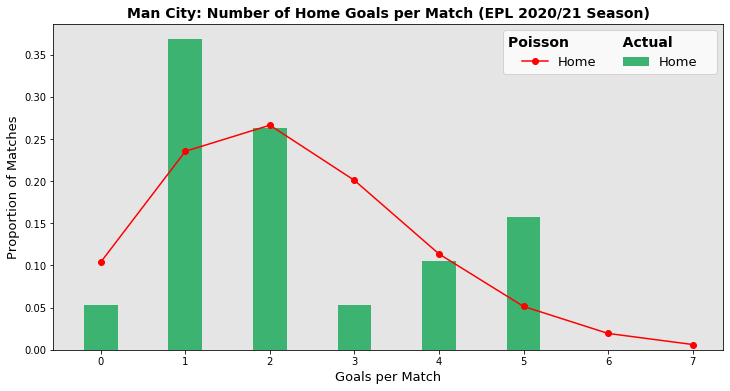

In [18]:
# modify these setting as appropriate to compare model fit
# teamnames can be accessed with the following: season_results['HomeTeam'].unique()
team='Man City'
home_or_away= 'Home'
season_results=football_results['epl20-21']
goal_freq=goal_frequencies(team,home_or_away,season_results)

#create plot
fig=plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.patch.set_facecolor('grey')
ax.patch.set_alpha(0.2)

#bar plot of goal frequencies
x=goal_freq.index
y=goal_freq.values[:,0]
plt.bar(x,y,width=0.4,align='center',label=home_or_away,color='mediumseagreen')


# now fit poisson distribution to goal frequency table

#rate parameter estimate is just sum-product of goal frequency table
rate_param = np.sum(np.multiply(goal_freq.T,goal_freq.index.T),axis=1)[0]

#get probabilities of number of goals scored per game using estimated rate parameter (i.e get poisson dist probabilities)
probabilities=[poisson.pmf(i,rate_param) for i in range(len(goal_freq)+2)]

#overlay poisson distribution on top of barplot
plt.plot(probabilities, marker='o', color='red', label=home_or_away)

# plot configuration
plt.xlabel('Number of goals scored per game')
plt.ylabel('Frequency/Probability')
plt.xlabel("Goals per Match",size=13)
plt.ylabel("Proportion of Matches",size=13)
leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Poisson           Actual        ", prop = {'size':'14', 'weight':'bold'})
plt.title(team+": Number of "+home_or_away+" Goals per Match (EPL 2020/21 Season)",size=14,fontweight='bold')

# Step 3: Parameter Fitting

We now estimate the parameters for our basic Poisson model. We use a Poisson regression model to estimate the parameters.

In [19]:
def poisson_regression_fit(season_results):
    """ 
    Fits a poisson regression model to a set of season match results. We create an additional binary variable 'home' that captures 
    whether the team played at home or not. We modify our dataframe of season results to incorporate this new variable. 
    For every result in our original dataframe, we need to create a duplicate where one
    observation shows that one team played at home (home=1) while the other observation shows that the other team played 
    away (home=0)
        
    Args:
        season_results: season_results is the dataframe consisting of the full set of match results for a given season

    Returns:
        statsmodel object: stats model object that contains coefficient estimates
    """
    
    goal_model_data = pd.concat([season_results[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
                columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
               season_results[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
                columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])
    
    #fit the model
    poisson_model = smf.glm(formula="goals ~ home+ team +opponent", data=goal_model_data, 
                            family=sm.families.Poisson()).fit()
    return poisson_model

In [20]:
#concatenate EPL and Championship results for 2020-21 into one dataframe
all_football_results_2021=pd.concat([football_results['epl20-21'],football_results['champ20-21']])

fit=poisson_regression_fit(all_football_results_2021)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                 1864
Model:                            GLM   Df Residuals:                     1777
Model Family:                 Poisson   Df Model:                           86
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2581.9
Date:                Mon, 16 Aug 2021   Deviance:                       2077.7
Time:                        00:35:31   Pearson chi2:                 1.82e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.0406      0.213      0.191      0.849      -0.377       0.458
team[T.Aston Villa]              0.0072      0.191      0.038      0.970      -0.367       0.381
team[T.Barnsley]                 0.1167      0.167      0.697      0.486      -0.211       0.445
team[T.Birmingham]              -0.3246      0.193     -1.679      0.093      -0.704       0.054
team[T.Blackburn]                0.2342      0.162      1.446      0.148      -0.083       0.552
team[T.Bournemouth]              0.3439      0.157      2.192      0.028       0.036       0.651
team[T.Brentford]                0.4197      0.154      2.732      0.006       0.119       0.721
team[T.Brighton]                -0.3120      0.208     -1.500      0.134      -0.720       0.096
team[T.Bristol City]            -0.1008      0.180     -0.561      0.575      -0.453       0.252
team[T.Burnley]                 -0.4956      0.220     -2.248      0.025      -0.928      -0.064
team[T.Cardiff]                  0.2453      0.161      1.522      0.128      -0.071       0.561
team[T.Chelsea]                  0.0502      0.188      0.266      0.790      -0.319       0.419
team[T.Coventry]                -0.0432      0.176     -0.245      0.806      -0.388       0.302
team[T.Crystal Palace]          -0.2667      0.207     -1.291      0.197      -0.672       0.138
team[T.Derby]                   -0.3545      0.195     -1.816      0.069      -0.737       0.028
team[T.Everton]                 -0.1483      0.199     -0.746      0.456      -0.538       0.241
team[T.Fulham]                  -0.6986      0.235     -2.970      0.003      -1.160      -0.238
team[T.Huddersfield]            -0.0147      0.175     -0.084      0.933      -0.358       0.328
team[T.Leeds]                    0.1357      0.186      0.731      0.464      -0.228       0.499
team[T.Leicester]                0.2242      0.182      1.235      0.217      -0.132       0.580
team[T.Liverpool]                0.2158      0.182      1.189      0.235      -0.140       0.572
team[T.Luton]                   -0.2291      0.187     -1.227      0.220      -0.595       0.137
team[T.Man City]                 0.4053      0.174      2.328      0.020       0.064       0.747
team[T.Man United]               0.2891      0.179      1.617      0.106      -0.061       0.640
team[T.Middlesbrough]            0.0659      0.170      0.388      0.698      -0.267       0.399
team[T.Millwall]                -0.0924      0.179     -0.517      0.605      -0.442       0.258
team[T.Newcastle]               -0.1555      0.200     -0.777      0.437      -0.548       0.237
team[T.Norwich]                  0.3627      0.156      2.329      0.020       0.057       0.668
team[T.Nott'm Forest]           -0.3376      0.193     -1.746      0.081    

## Home Advantage
As mentioned in the report, the rate at which the home team scores depends on an extra parameter known as 'home advantage'. We
investigate how this parameter behaved in previous seasons.

In [21]:
#blank list to store results
home_adv_hist=[]

#we only care about home effect in Premier League
division='epl'

#fit a poisson regression model for every PL season and store the estimate for the 'home' parameter in a list
for season in season_hist:
            fit=poisson_regression_fit(football_results[division+season])
            home_adv_hist.append(fit.params.loc['home'])

#create a series/dataframe using the season as an index
home_adv_hist=pd.Series(index=season_hist,data=home_adv_hist)
home_adv_hist

93-94    0.220132
94-95    0.336185
95-96    0.351761
96-97    0.307556
97-98    0.326723
98-99    0.309005
99-00    0.401536
00-01    0.371138
01-02    0.226741
02-03    0.281851
03-04    0.262364
04-05    0.341749
05-06    0.355389
06-07    0.376012
07-08    0.322118
08-09    0.260486
09-10    0.457983
10-11    0.324550
11-12    0.268009
12-13    0.228649
13-14    0.275494
14-15    0.299658
15-16    0.211309
16-17    0.283845
17-18    0.288828
18-19    0.224823
19-20    0.229238
20-21    0.007813
dtype: float64

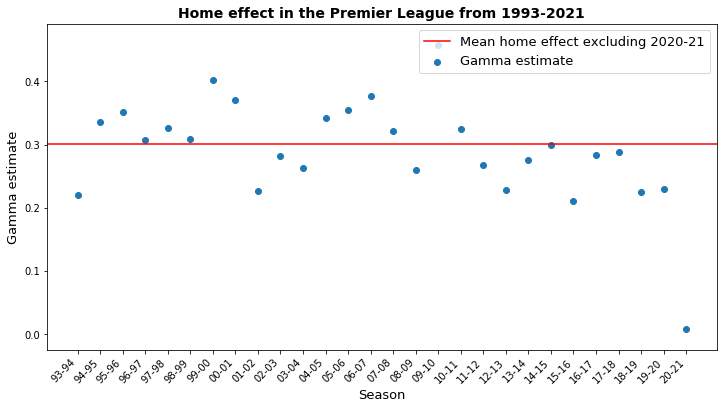

In [22]:
#Plot home effect for every season
plt.figure(figsize=(12, 6))
plt.scatter(home_adv_hist.index,home_adv_hist,label='Gamma estimate')
plt.xticks(rotation=45,ha='right')
plt.title('Home effect in the Premier League from 1993-2021',size=14,fontweight='bold')
plt.ylabel("Gamma estimate",size=13)
plt.xlabel("Season",size=13)

# we exclude last season's estimate and take the mean of all the remaining estimates
# this will be the constrained home effect for 2021-22 simulation
opt_gamma=home_adv_hist[:-1].mean()
plt.axhline(y=opt_gamma,color='red',linestyle='-',label='Mean home effect excluding 2020-21')
leg=plt.legend(loc='upper right', fontsize=13, ncol=1)

In [23]:
# This is the same poisson_regression_fit function as defined before with the exception of a constraint on the 'home' variable
# we need to hardcode this value rather than use the variable ('opt_gamma')

def poisson_regression_fit_final(season_results):
    goal_model_data = pd.concat([season_results[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
                columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
               season_results[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
                columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

    poisson_model = smf.glm(formula="goals ~ home+ team +opponent", data=goal_model_data, 
                            family=sm.families.Poisson()).fit_constrained('home=0.3015')
    return poisson_model

## Promoted/Relegated Teams adjustment
Once we estimate the parameters from the Poisson regression model, we need to adjust (downweight) the parameters for the 
promoted teams. To apply an appropriate adjustment, we look at how promoted teams fared historically in the Premier League. More
explicitly, we look at their goal statistics (average number of goals scored per game and average number of goals 
conceded per game) in their promotion winning season vs their subsequent season in the Premier League. We fit a linear model to
this data which will be used to downweight the promoted teams strength in the simulation.

Note that GA (Goals Against) refers to goals conceded by a team while GF (Goals For) corresponds to goals scored by a team

In [24]:
from itertools import chain

#blank list to store the promoted teams
prom_teams_list=[]
#blank list to store the average goals scored by each promoted team in the season they won promotion
GF_Champ=[]
#blank list to store the average goals scored by each promoted team the subsquent year in the Premier League
GF_PL=[]
#blank list to store the average goals conceded by each promoted team in the season they won promotion
GA_Champ=[]
#blank list to store the average goals conceded by each promoted team the subsquent year in the Premier League
GA_PL=[]


#loop through every season
for i in range(0,len(season_hist)-2):
    
    #promoted teams will be intersection of teams who played in Championship in season t and teams 
    # who played in the PL in season t+1
    A=football_results['champ'+season_hist[i]]['HomeTeam'].unique()
    B=football_results['epl'+season_hist[i+1]]['HomeTeam'].unique()
    pro_teams=list(set(A)&set(B))
    
    #store the relevant goal statistics for each promoted team by accessing historic league table
    prom_teams_list.append(pro_teams)
    GF_Champ.append(list(football_tables['champ'+season_hist[i]].loc[pro_teams]['GF avg'].values))
    GF_PL.append(list(football_tables['epl'+season_hist[i+1]].loc[pro_teams]['GF avg'].values))
    GA_Champ.append(list(football_tables['champ'+season_hist[i]].loc[pro_teams]['GA avg'].values))
    GA_PL.append(list(football_tables['epl'+season_hist[i+1]].loc[pro_teams]['GA avg'].values))

#un-nest the lists using chain so we can make into a dataframe
prom_teams_list = list(chain(*prom_teams_list))
GF_Champ = list(chain(*GF_Champ))   
GF_PL=list(chain(*GF_PL))
GA_Champ = list(chain(*GA_Champ))   
GA_PL=list(chain(*GA_PL)) 

#put all data into a dataframe
prom_data= {'Promoted Team':prom_teams_list,'GF_Champ':GF_Champ,'GF_PL':GF_PL,
    'GA_Champ':GA_Champ,'GA_PL':GA_PL}
prom_df = pd.DataFrame(data=prom_data)
prom_df


,Promoted Team,GF_Champ,GF_PL,GA_Champ,GA_PL
0,Leicester,1.565217,1.071429,1.282609,1.904762
1,Nott'm Forest,1.608696,1.714286,1.065217,1.023810
2,Crystal Palace,1.586957,0.809524,1.000000,1.166667
3,Bolton,1.456522,1.026316,0.978261,1.868421
4,Middlesbrough,1.456522,0.921053,0.869565,1.315789
...,...,...,...,...,...
72,Wolves,1.782609,1.236842,0.847826,1.210526
73,Fulham,1.717391,0.894737,1.000000,2.131579
74,Sheffield United,1.695652,1.026316,0.891304,1.026316
75,Norwich,2.021739,0.684211,1.239130,1.973684


We now fit two linear models: 1) Regress a promoted teams GF (Goals For) rate in the Premier League against their GF rate in The Championship
the season prior and 2) Regress a promoted teams GA (Goals Against) rate in the Premier League against their GA rate in The Championship
the season prior.

In [25]:
#model that will make adjustents to promoted teams
promotion_model_GA = smf.ols(formula="GA_PL ~ GA_Champ", data=prom_df).fit()
promotion_model_GF = smf.ols(formula="GF_PL ~ GF_Champ", data=prom_df).fit()

#model that will make adjustents to relegated teams - just inversion of promotion models
relegation_model_GA = smf.ols(formula="GA_Champ ~ GA_PL", data=prom_df).fit()
relegation_model_GF = smf.ols(formula="GF_Champ ~ GF_PL", data=prom_df).fit()

promotion_model_GA.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  GA_PL   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     4.319
Date:                Mon, 16 Aug 2021   Prob (F-statistic):             0.0411
Time:                        00:35:35   Log-Likelihood:                -12.333
No. Observations:                  77   AIC:                             28.67
Df Residuals:                      75   BIC:                             33.35
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2267      0.182      6.741      0.000       0.864       1.589
GA_Champ       0.3758      0.181      2.078      0.041       0.016       0.736
==============================================================================
Omnibus:                        1.953   Durbin-Watson:                   2.438
Prob(Omnibus):                  0.377   Jarque-Bera (JB):                1.847
Skew:                           0.288   Prob(JB):                        0.397
Kurtosis:                       2.506   Cond. No.                         11.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

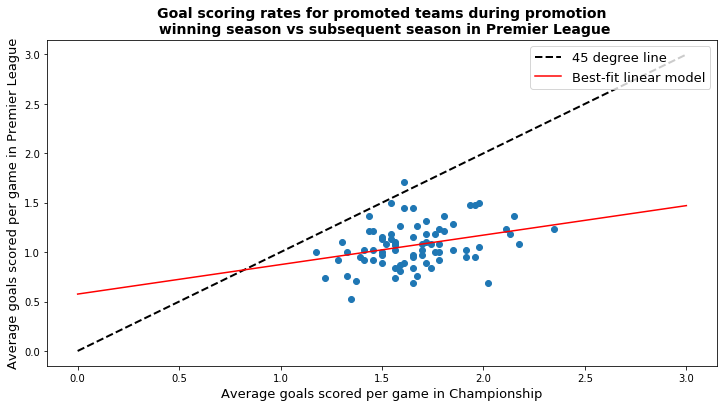

In [26]:
#plot promotion_model_GF data
fig,ax=plt.subplots(figsize=(12,6))
x=prom_df['GF_Champ']
y=prom_df['GF_PL']
ax.scatter(x,y)

#45 degree line
plt.plot([0,3 ], [0, 3], color = 'black', linewidth = 2,linestyle='--', label='45 degree line')

#best fit line
plt.plot([0,3], np.poly1d(np.polyfit(x, y, 1))([0,3]),color='red',label='Best-fit linear model')

#configure plot
plt.title('Goal scoring rates for promoted teams during promotion\n winning season vs subsequent season in Premier League',size=14,fontweight='bold')
plt.ylabel("Average goals scored per game in Premier League",size=13)
plt.xlabel("Average goals scored per game in Championship",size=13)
leg=plt.legend(loc='upper right', fontsize=13, ncol=1)

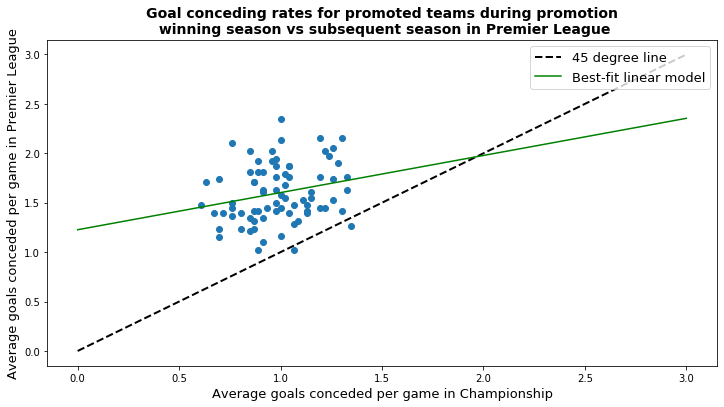

In [27]:
#plot promotion_model_GA data
fig,ax=plt.subplots(figsize=(12,6))
x=prom_df['GA_Champ']
y=prom_df['GA_PL']
ax.scatter(x,y)

#45 degree line
plt.plot([0,3 ], [0, 3], color = 'black', linewidth = 2,linestyle='--', label='45 degree line')

#best fit line
plt.plot([0,3], np.poly1d(np.polyfit(x, y, 1))([0,3]),color='green',label='Best-fit linear model')

#configure plot
plt.title('Goal conceding rates for promoted teams during promotion\n winning season vs subsequent season in Premier League',size=14,fontweight='bold')
plt.ylabel("Average goals conceded per game in Premier League",size=13)
plt.xlabel("Average goals conceded per game in Championship",size=13)
leg=plt.legend(loc='upper right', fontsize=13, ncol=1)

# Step 4: Simulation

As part of the simulation, we need to define two sets of functions that will determine the relegated/promoted teams 
and update the teams. We use the first set of functions to update the teams when simulating the first season only - this is
because the 3rd place team in The Championship does not get promoted (determined by play-off). To get promoted teams historically, we find the teams who
competed in The Championship one year and then competed in the Premier League the subsequent year and take the intersection of these two sets.
This first set of functions can be used to back-test a previous season hence the need for them.

In our simulation, we assume the 3rd place team in the Championship does get promoted (for simplification) and therefore only
a single league table is needed to determine promoted/relegated teams.These sets of functions will be used for simulating the second season onwards

In [28]:
#First set of functions
def get_promoted_teams_hist(season):
    """ 

    Args:
        season: season in string format
    Returns:
        list: a list of the teams who achieved promotion that season
    """    
    
    if season != '20-21':
        A=football_results['champ'+season]['HomeTeam'].unique()
        
        #get the following season in string format
        fol_season=season_hist[season_hist.index(season)+1]
        
        B=football_results['epl'+fol_season]['HomeTeam'].unique()
        prom_teams=list(set(A)&set(B))
    else:
        #hard code 20-21 promoted teams - only way
        prom_teams=['Brentford','Norwich','Watford']
    return prom_teams

def update_teams_hist(season,epl_league_table,champ_league_table, div):
    """ 
    This function calculates the participating teams for a specified division for a specified historical season.
    Args:
        season: season in string format
        div: Whether the division is Premier League ('epl') or Championship ('champ')
    Returns:
        list: a list of the teams who participated in the specified division in the specified season
    """
    if div=='epl':
        n_teams= len(epl_league_table)
        current_teams=list(epl_league_table.iloc[0:n_teams-3].index)
        rel_teams=get_relegated_teams(epl_league_table)
        prom_teams=get_promoted_teams_hist(season)
        teams=current_teams+prom_teams
    if div=='champ':
        n_teams= len(champ_league_table)
        current_teams=list(champ_league_table.iloc[3:n_teams].index)
        rel_teams=get_relegated_teams(epl_league_table)
        teams=current_teams+rel_teams
    return teams

In [29]:
#2nd set of functions 
def get_promoted_teams(champ_league_table):
    """ 
    Determines the promoted teams from the final Championship table. This function is to be used for determining promoted teams
    during the simulation (not for historical)
    
    Args:
        champ_league_table: final league table of The Championship
    Returns:
        list: a list of the teams who achieved promotion that season
    """     
    #promoted teams are teams that finish 1st-3rd place in the Championship
    prom_teams=list(champ_league_table.iloc[0:3].index)
    return prom_teams

def get_relegated_teams(epl_league_table):
    """ 
    Determines the relegated teams from the final Premier League table. This function can be used for determining relegated
    teams during the simulation and for historical purposes.
    
    Args:
        epl_league_table: final league table of the Premier League
    Returns:
         list: a list of the teams who were relegated that season
        """    
    #teams relegated are those that finish in 18th-20th place in the EPL
    n_teams= len(epl_league_table)
    rel_teams=list(epl_league_table.iloc[n_teams-3:n_teams].index)
    return rel_teams

def update_teams(epl_league_table,champ_league_table, div):
    """ 
     This function calculates the participating teams in the next iteration of a season using the previous 
     final Premier League and Championship tables.
    
    Args:
        epl_league_table: final league table of the Premier League
        champ_league_table: final league table of the Championship
    Returns:
         list: a list of the teams participating in the next season for the specified division
        """  
    if div=='epl':
        n_teams= len(epl_league_table)
        
        #current teams are those that avoided relegation i.e top 17 teams
        current_teams=list(epl_league_table.iloc[0:n_teams-3].index)
        
        rel_teams=get_relegated_teams(epl_league_table)
        prom_teams=get_promoted_teams(champ_league_table)
        
        #merge current teams with promoted teams to get final team list for PL for next season
        teams=current_teams+prom_teams
    
    if div=='champ':
        n_teams= len(champ_league_table)
        
        #current teams are those that avoided promotion
        current_teams=list(champ_league_table.iloc[3:n_teams].index)
        rel_teams=get_relegated_teams(epl_league_table)
        
        #merge current teams with relegated teams to get final team list for Championship for next season
        teams=current_teams+rel_teams
    return teams

The ***'calc_means'*** function will be used to set the means (attack/defence strength) for each team for each fixture. The fitted poisson model provides the unadjusted
means for all the teams but we need to adjust the means for the promoted teams as discussed already.

We only need to make an adjustment when a promoted team plays a non-promoted team (i.e no adjustment needed
when a promoted side plays a promoted team in the PL). We downweight the promoted teams scoring rate using the fitted linear model ***promotion_model_GF*** and upweight
the oppositions scoring rate against the promoted team using the fitted linear model ***promotion_model_GA***

We apply the exact same process to the relegated teams when simulating the Championship - i.e upweight the relegated teams scoring rate
and downweight the opposition's scoring rate by inverting the same fitted models.

In [30]:
def calc_means(model_fit,homeTeam, awayTeam, division, prom_teams, rel_teams):
    """ 
     This function calculates the means (Poisson rate) for the home and away team for a given fixture. Adjustments are
     applied to the (unadjusted) Poisson rates for games involving promoted/relegated teams.
    
    Args:
        model_fit: fitted poisson regression model in use for this season
        homeTeam: home team in the given fixture
        awayTeam: away team in the given fixture
        division: Whether the division is the Premier League ('epl') or Championship ('champ')
        prom_teams: teams who achieved promotion last season
        rel_teams: teams who were relegated last season
    
    Returns:
         list: a list of two: the first element is the home team's Poisson rate while the second element is the away
               team's Poisson rate.
        """  
    
    #get unadjusted means for home team and away team using the poisson regression model fit
    home_param=model_fit.predict(pd.DataFrame(data={'team': homeTeam, 'opponent': awayTeam,
                                       'home':1},index=[0]))[0]
    away_param= model_fit.predict(pd.DataFrame(data={'team':awayTeam, 'opponent': homeTeam,
                                       'home':0},index=[0]))[0]
    if division=='epl':
        
        # no adjustment needed when prom team vs prom team
        # keep unadjusted rates
        if (homeTeam in prom_teams) and (awayTeam in prom_teams):
            return [home_param, away_param]
        
        # prom team (home) vs non-prom team (away)
        # apply linear model to adjust means for both teams
        elif (homeTeam) in prom_teams:
            home_adj_param=promotion_model_GF.predict(pd.DataFrame({'GF_Champ': [home_param]}))[0]
            away_adj_param=promotion_model_GA.predict(pd.DataFrame({'GA_Champ': [away_param]}))[0]
            return [home_adj_param,away_adj_param]
        
        #non-prom team (home) vs prom team (away)
        # apply linear model to adjust means for both teams
        elif (awayTeam) in prom_teams:
            home_adj_param=promotion_model_GA.predict(pd.DataFrame({'GA_Champ': [home_param]}))[0]
            away_adj_param=promotion_model_GF.predict(pd.DataFrame({'GF_Champ': [away_param]}))[0]
            return [home_adj_param,away_adj_param]
        
        # only other case is a non-promoted team vs non-promoted team
        # use unadjusted rates
        else:
            return [home_param, away_param]
    
    # apply same adjustmnents to the relegated teams when the division is The Championship    
    else:
        if (homeTeam in rel_teams) and (awayTeam in rel_teams):
            return [home_param, away_param]

        elif (homeTeam) in rel_teams:
            home_adj_param=relegation_model_GF.predict(pd.DataFrame({'GF_PL': [home_param]}))[0]
            away_adj_param=relegation_model_GA.predict(pd.DataFrame({'GA_PL': [away_param]}))[0]      
            return [home_adj_param,away_adj_param]

        elif (awayTeam) in rel_teams:
            home_adj_param=relegation_model_GA.predict(pd.DataFrame({'GA_PL': [home_param]}))[0]
            away_adj_param=relegation_model_GF.predict(pd.DataFrame({'GF_PL': [away_param]}))[0]
            return [home_adj_param,away_adj_param]
        
        else:
            return [home_param, away_param]




In [31]:
def simulate_outcome_goals(team_params):
    """ 
     This function simulates the number of goals for the home and away teams based on the Poisson rates for each team.
    
    Args:
        team_params (list): Adjusted Poisson rates for the home team and away team, first element is home team's rate second
        element is away team's rate
    
    Returns:
         list: a list of two: the first element is the home team's simulated goals while the second element is the away
               team's simulated goals.
        """ 
    goals_sim=[np.random.poisson(lam=team_params[0]),np.random.poisson(lam=team_params[1])]
    return goals_sim

In [32]:
import itertools

def get_fixture_list(teams):
    """ 
     This function creates a fixture list from a list of teams.
    
    Args:
         teams (list): List of teams who will participating in an iteration of the Premier League/Championship.
    
    Returns:
         list: fixture list for the division for the season ahead
        """    
    #creates a fixture list by creating all permutations of two teams from the team list
    fixture_list=list(itertools.permutations(teams, 2))
    
    return fixture_list

def simulate_league(teams,model_fit,division, prom_teams, rel_teams):
    """ 
     This function simulates the league of choice (Premier League or Championship)
    
    Args:
         teams (list): List of teams who will be participating in this iteration of the Premier League/Championship.
         model_fit (statsmodel): fitted poisson regression model in use for season ahead
         division (string): Whether the league to simulate should be the Premier League or Championship
         prom_teams (list): list of teams who achieved promotion to Premier League last season
         rel_teams (list): list of teams who were relegated to Championship last season
    
    Returns:
         tuple: first element is the simulated match results, second element is the final league table
    """      
    #initialise blank league table
    #For each team:
    # P = Matches Played
    # W = Matches Won
    # D = Matches Drawn
    # L = Matches Lost
    # GF = Goals Scored
    # GA = Goals Conceded
    # GD = Goal Difference
    # PTS = Total Points

    c=['P','W','D','L','GF','GA','GD','PTS']
    league_table=pd.DataFrame(data=0,columns=c,index=teams)

    #blank list to store match results for entire season
    season_results=[]

    #get the fixture list for the season using the teams that will play that season
    fixture_list=get_fixture_list(teams)

    for fixture in fixture_list:

            #fixture is a tuple with first element the home team and 2nd element the away team
            hometeam=fixture[0]
            awayteam=fixture[1]

            #calculates the rate parameters (i.e lambdas) for home team and away team for given fixture using the fit 
            #poisson regression model
            team_params=calc_means(model_fit,hometeam,awayteam,division,prom_teams,rel_teams)

            #simulates the number of goals for home team and away team using the rate parameters that have been calculated 
            #score is a tuple with first element the number of goals scored by home team and second element the 
            #number of goals scored by away team
            score = simulate_outcome_goals(team_params)

            #update the league table based on outcome:
            #hometeam and awayteam have played an additional game so add 1 to both team games played column ('P') on the table
            league_table.loc[hometeam]['P']+=1
            league_table.loc[awayteam]['P']+=1

            #update the home and away teams goals scored/conceded on the table based on the simulated score.
            league_table.loc[hometeam]['GF']+=score[0]
            league_table.loc[hometeam]['GA']+=score[1]
            league_table.loc[awayteam]['GF']+=score[1]
            league_table.loc[awayteam]['GA']+=score[0]

            # if home team scores more goals than away team then home team wins and gets 3 pts for a win
            if score[0]>score[1]:      
                league_table.loc[hometeam]['PTS']+=3
                league_table.loc[hometeam]['W']+=1
                league_table.loc[awayteam]['L']+=1

            # if home team and away team score same number of goals then the outcome is a draw and both teams get 1 pt each
            elif score[0]==score[1]:
                league_table.loc[hometeam]['PTS']+=1
                league_table.loc[awayteam]['PTS']+=1
                league_table.loc[hometeam]['D']+=1
                league_table.loc[awayteam]['D']+=1

            # only other outcome is if away team scores more goals than home team so away team gets 3 pts
            else:
                league_table.loc[awayteam]['PTS']+=3
                league_table.loc[awayteam]['W']+=1
                league_table.loc[hometeam]['L']+=1

            # save each match result (will be needed)
            match_result=[hometeam,awayteam,score[0],score[1]]
            season_results.append(match_result)

    #convert match results to dataframe for ease
    c2=['HomeTeam','AwayTeam','HomeGoals','AwayGoals']
    season_results=pd.DataFrame(data=season_results,columns=c2)

    #update the Goal Difference for each team
    league_table['GD']=league_table['GF']-league_table['GA']

    # sort the final table based on total points (PTS)
    # if both teams finish level on points then use Goal Difference to decide who finishes higher
    final_table=league_table.sort_values(['PTS','GD'],ascending=[False,False])

    #return both the final table and season results
    return (final_table, season_results)


In [33]:
def simulate(n_seasons=1,last_season='20-21'):
    """ 
    Simulates the Premier League/Championship forward a specified number of seasons. This is one full iteration within the
    Monte Carlo simulation.
        
    Args:
        n_seasons (integer): number of seasons to simulate forward
        last_season (string): the season to which the model parameters should be calibrated (i.e previous season)

    Returns:
        list:  list of premier league tables (dataframes) for each season
    """     
    results=[]
    
    for j in range(0,n_seasons):
        
        #j==0 is the first season which requires historical data to estimate parameters 
        if j==0:
            #all functions defined already
            prom_teams=get_promoted_teams_hist(last_season)
            rel_teams=get_relegated_teams(football_tables['epl'+last_season])
            epl_teams=update_teams_hist(last_season,football_tables['epl'+last_season],
                                        football_tables['champ'+last_season],'epl')
            champ_teams=update_teams_hist(last_season,football_tables['epl'+last_season],
                                          football_tables['champ'+last_season],'champ')
            model_fit=poisson_regression_fit_final(pd.concat([football_results['epl'+last_season],
                                                        football_results['champ'+last_season]]))
        
        #j>0 - use simulated data to estimate paramters for season 2 onwards
        else:
            prom_teams=get_promoted_teams(champ_table)
            rel_teams=get_relegated_teams(epl_table)
            epl_teams=update_teams(epl_table,champ_table,'epl')
            champ_teams=update_teams(epl_table,champ_table,'champ')
            model_fit=poisson_regression_fit_final(pd.concat([epl_results,champ_results]))

        #Simulate EPL and Championship
        (epl_table,epl_results)=simulate_league(epl_teams,model_fit,'epl',prom_teams,rel_teams)
        (champ_table,champ_results)=simulate_league(champ_teams,model_fit,'champ',prom_teams,rel_teams)
        results.append(epl_table)
    return results


***mc_simulation*** performs the Monte Carlo simulation. This is a very slow computation where one iteration of one season forward takes 30 seconds to run.

In [54]:
#WARNING: running a large number of iterations will take a LONG time (1000 iter takes roughly 7.5 hrs)

def mc_simulation(n_iter,n_seasons,last_season):
    """ 
    Simulates the Premier League/Championship forward a specified number of seasons for a specified number of iterations
        
    Args:
        n_iter (string): number of iterations
        n_seasons (integer): number of seasons to simulate forward
        last_season (string): the season to which the model parameters should be calibrated (i.e previous season)

    Returns:
        list:  nested list with each sublist corresponding to one iteration (one iteration contains a list of league tables)
    """  
    res=[]
    for _ in range(n_iter):
        sim=simulate(n_seasons,last_season)
        res.append(sim)
    return res  

In [55]:
#test
#adjust as needed
mc_simulation(n_iter=1,n_seasons=1,last_season='20-21')

[[                 P   W   D   L  GF  GA  GD  PTS
  Man City        38  27   6   5  85  31  54   87
  Chelsea         38  21  10   7  72  45  27   73
  Man United      38  20   8  10  72  57  15   68
  Liverpool       38  18  10  10  69  51  18   64
  West Ham        38  17  11  10  64  46  18   62
  Tottenham       38  17   8  13  64  43  21   59
  Leicester       38  15  12  11  64  41  23   57
  Leeds           38  16   8  14  60  60   0   56
  Aston Villa     38  13  12  13  51  50   1   51
  Arsenal         38  14   8  16  43  43   0   50
  Norwich         38  14   7  17  55  65 -10   49
  Brighton        38  14   6  18  45  51  -6   48
  Newcastle       38  13   9  16  47  60 -13   48
  Burnley         38  12  10  16  41  48  -7   46
  Wolves          38  13   7  18  46  61 -15   46
  Brentford       38  10  15  13  53  65 -12   45
  Everton         38  10  10  18  38  62 -24   40
  Watford         38   8  14  16  43  60 -17   38
  Crystal Palace  38   9   6  23  41  77 -36   33


In [36]:
# keep this cell commented-this was the code to generate the simulations
# we load the data in instead


# mc_res_backtest=mc_simulation(n_iter=1000,n_seasons=1,last_season='19-20')
# mc_res_oneseason=mc_simulation(n_iter=1000,n_seasons=1,last_season='20-21')
# mc_res_10seasons=mc_simulation(n_iter=260,n_seasons=10,last_season='20-21')

# Step 5: Analyse Results

Rather than have the user compute the simulations manually, we load in the results of our simulations below. There are 3 sets of
simulations run for this project, each for a different purpose.

In [37]:
import pickle
with open('mc_res_backtest.pickle', 'rb') as f:
    mc_res_backtest = pickle.load(f)
    
with open('mc_res_oneseason.pickle', 'rb') as f:
    mc_res_oneseason = pickle.load(f)
    
with open('mc_res_10seasons.pickle', 'rb') as f:
    mc_res_10seasons = pickle.load(f)

## Monte Carlo Backtest of 2020-21 season

In [38]:
def get_average_table(mc_results):
    """ 
    Computes the average Premier League table from a list of Premier League tables.
        
    Args:
        mc_results (list of dataframes): list of Premier League tables (Monte Carlo output object)

    Returns:
        dataframe:  Average Premier League table
    """ 
    #to store league tables
    tables=[]
    
    for simulated_table in mc_results:
        #sort each table alphabetically so that each team's index is constant over the simulations
        tables.append(simulated_table.sort_index())
    
    #take each team's average stats (GA, GF , W, D, L, PTS) across all simulations and sort the average table by points
    average_table=(sum(tables)/len(mc_results)).sort_values(['PTS','GD'],ascending=[False,False])
    
    return average_table


In [39]:
#each iteration is in a sublist so flatten the list
mc_res_backtest=list(chain(*mc_res_backtest))

backtest_avg_table=get_average_table(mc_res_backtest)
backtest_avg_table

,P,W,D,L,GF,GA,GD,PTS
Man City,38.0,26.111,6.486,5.403,93.052,36.401,56.651,84.819
Liverpool,38.0,24.144,7.529,6.327,78.904,34.532,44.372,79.961
Man United,38.0,20.245,9.067,8.688,62.898,37.192,25.706,69.802
Leicester,38.0,19.400,8.755,9.845,63.814,42.109,21.705,66.955
Tottenham,38.0,16.978,8.984,12.038,59.031,48.563,10.468,59.918
Chelsea,38.0,17.085,8.359,12.556,65.095,54.717,10.378,59.614
Wolves,38.0,16.277,10.001,11.722,50.310,41.257,9.053,58.832
Arsenal,38.0,15.832,9.291,12.877,54.485,48.942,5.543,56.787
Sheffield United,38.0,13.677,11.003,13.320,40.591,40.272,0.319,52.034
Burnley,38.0,12.852,9.741,15.407,43.516,50.405,-6.889,48.297


We will now produce a boxplot of each team's final points tally from our 2020-21 Monte Carlo simulation. We compare this to each team's
actual points tally for 2020-21.

In [40]:
#get teams who competed
team_list=backtest_avg_table.index.values

#to store each team's points distribution
pts_list=[]

#get each team's points tally across all simulations and store
for team in team_list:
    pts=[sim.loc[team]['PTS'] for sim in mc_res_backtest]
    pts_list.append(pts)

#create dictionary to store data
pts_dict=dict(zip(team_list,pts_list))


In [41]:
#Now get each team's historic actual points for the season
hist_pts=football_tables['epl20-21']['PTS']

#re-index so teams in same order as average table (needed for plotting purposes)
hist_pts=hist_pts.reindex(backtest_avg_table.index)


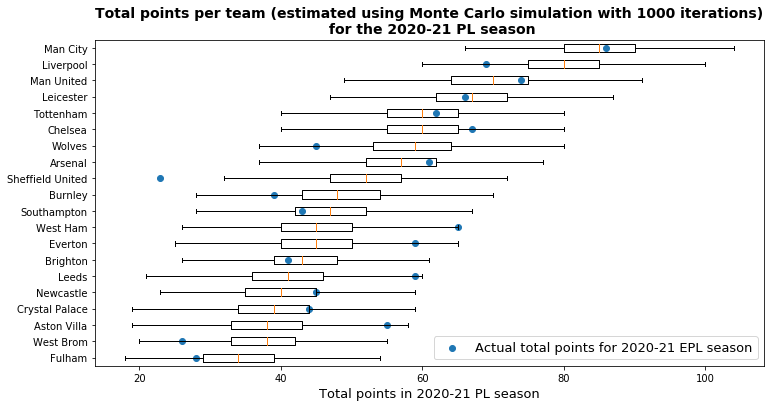

In [42]:
fig = plt.figure(figsize=(12,6))

#the labels are the teams - reverse the label order so 1st place team is top in the boxplot (not on the bottom)
teams=list(pts_dict.keys())[::-1]

#points distribution per team - needs to be consistent with labels so reverse again
pts_dist=list(pts_dict.values())[::-1]

#teams on y axis, points on x-axis
plt.boxplot(x=pts_dist,labels=teams,vert=False,showfliers=False)

#overlay historic points on boxplot for each team
x=list(hist_pts.values)[::-1]
y=list(range(1,len(teams)+1))
plt.scatter(x,y,label='Actual total points for 2020-21 EPL season')

#configure plot
plt.title('Total points per team (estimated using Monte Carlo simulation with 1000 iterations)\n for the 2020-21 PL season',size=14,fontweight='bold')
plt.xlabel("Total points in 2020-21 PL season",size=13)
leg=plt.legend(loc='lower right', fontsize=13, ncol=1)

## Forward Simulation of 2021-22 PL season

In [43]:
def get_events(mc_results):
    """ 
    Gets 1) champions for each iteration 
         2) the relegated teams for each iteration
         3) top four teams for each iteration
    
    Stored in a dictionary 
    
    Args:
        mc_results (list of dataframes): list of Premier League tables (Monte Carlo output object)

    Returns:
        dictionary:  1) 'Champions': champions for each iteration 
                     2) 'Relegated': the relegated teams for each iteration
                     3) 'Top 4': top four teams for each iteration
    """ 
    #to store results
    champions_list=[]
    relegated_list=[]
    top4_list=[]
    
    for simulated_table in mc_results:
        
        #index 0 is 1st position in table...etc
        champions_list.append(simulated_table.index[0])
        relegated_list.append(simulated_table.index[17:20])
        top4_list.append(simulated_table.index[0:4])
    return {'Champions':champions_list, 'Relegated': relegated_list, 'Top 4':top4_list}

In [52]:
#get event data and average table
champions_list=get_events(mc_res_oneseason)['Champions']
relegated_list=get_events(mc_res_oneseason)['Relegated']
top_four_list=get_events(mc_res_oneseason)['Top 4']
get_average_table(mc_res_oneseason)

,P,W,D,L,GF,GA,GD,PTS
Man City,38.00,23.72,7.80,6.48,76.96,34.67,42.28,78.97
Man United,38.00,19.42,8.56,10.02,68.70,46.44,22.25,66.83
Liverpool,38.00,18.96,8.72,10.32,64.68,44.56,20.11,65.61
Chelsea,38.00,18.22,9.71,10.06,56.07,38.75,17.32,64.38
Tottenham,38.00,18.21,8.80,10.99,64.56,47.51,17.05,63.44
Leicester,38.00,17.22,8.59,12.19,64.25,52.48,11.77,60.25
Arsenal,38.00,16.80,9.76,11.44,53.47,41.86,11.60,60.16
West Ham,38.00,16.70,8.99,12.31,59.38,49.45,9.93,59.09
Aston Villa,38.00,15.36,9.50,13.14,53.14,48.48,4.66,55.58
Leeds,38.00,15.36,8.81,13.83,59.37,56.18,3.19,54.89


In [45]:
#initialise dataframe to store results (i.e to store probability of champion, relegated and top 4)
pd.options.display.float_format = "{:,.2f}".format
c=['MC_champions','MC_top4', 'MC_relegation']
prob_table=pd.DataFrame(data=float(0.00),columns=c,index=get_average_table(mc_res_oneseason).index)

In [46]:
#get unique elements of each list
unique_champions_list=np.unique(np.array(champions_list))
unique_topfour_list=np.unique(np.array(top_four_list))
unique_rel_list=np.unique(np.array(relegated_list))

#calculate probabilities for the events (champion,relegation and top 4) for each team by taking the average of the simulations
# assign result to each team in dataframe

for team in unique_champions_list:
    prob_table.loc[team]['MC_champions']=champions_list.count(team)/len(champions_list)

for team in unique_topfour_list:
    prob_table.loc[team]['MC_top4']=list(chain(*top_four_list)).count(team)/len(top_four_list)
    
for team in unique_rel_list:
    prob_table.loc[team]['MC_relegation']=list(chain(*relegated_list)).count(team)/len(relegated_list)

In [47]:
#Betfair Odds
#taken from betfair website on 11/8
betfair_champion_odds_dict={'Man City':1.805,'Chelsea':6.3,'Liverpool':7.1,'Man United':10.25,'Leicester':72.5,'Arsenal':77.5,
             'Tottenham':90,'Leeds':210,'Aston Villa':245,'West Ham':300,'Everton':380}

betfair_rel_odds_dict={'Leicester':77.5,'Arsenal':77.5,'Brighton':11.25,'Wolves':7.3,'Southampton':4.55,'Newcastle':3.92,
             'Burnley':3.17,'Crystal Palace':2.73,'Brentford':2.54, 'Tottenham':90,'Leeds':17.5,'Aston Villa':13,
                       'Watford':2.03,'Norwich':2.01,'West Ham':14.5,'Everton':21}
#store odds in a list
bf_list_odds=[betfair_champion_odds_dict,betfair_rel_odds_dict]


# we need implied probabilities (not odds) so the loop below gets the implied probabilities and puts them back into a dictionary
# with the teams as keys
bf_list_prob=[]
for item in bf_list_odds:
    #invert the odds to get implied probabilities
    prob=1/(np.array(list(item.values())))

    betfair_prob_dict=dict(zip(item.keys(),prob))
    bf_list_prob.append(betfair_prob_dict)

#put Betfair probabilities into a dataframe and rename columns
betfair_prob_df=pd.DataFrame([bf_list_prob[0],bf_list_prob[1]]).transpose()
betfair_prob_df.columns=['Betfair_champions','Betfair_relegation']

#concatenate the Monte Carlo probabilities and Betfair probabilities for all the teams into one dataframe
all_prob = pd.concat([betfair_prob_df,prob_table],axis=1,sort=False)

#replace nan with 0
all_prob.fillna(0)

,Betfair_champions,Betfair_relegation,MC_champions,MC_top4,MC_relegation
Man City,0.55,0.00,0.70,0.97,0.00
Chelsea,0.16,0.00,0.05,0.45,0.00
Liverpool,0.14,0.00,0.07,0.55,0.00
Man United,0.10,0.00,0.07,0.60,0.00
Leicester,0.01,0.01,0.02,0.26,0.00
Arsenal,0.01,0.01,0.01,0.25,0.00
Tottenham,0.01,0.01,0.04,0.42,0.00
Leeds,0.00,0.06,0.00,0.10,0.01
Aston Villa,0.00,0.08,0.01,0.10,0.01
West Ham,0.00,0.07,0.02,0.24,0.00


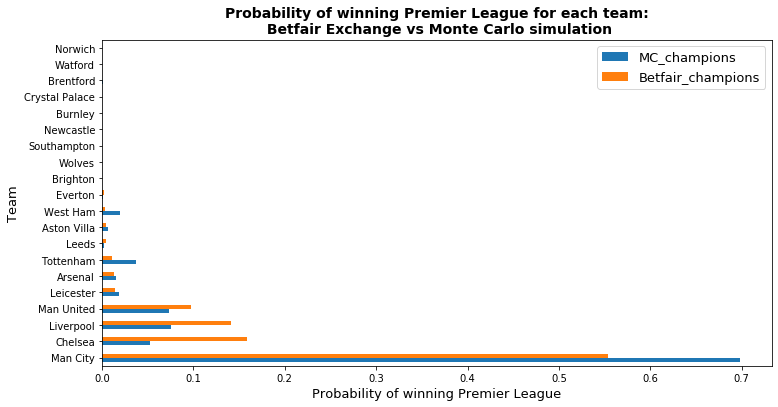

In [48]:
#isolate champion probabilities from MC simulataion and Betfair
all_prob[['MC_champions','Betfair_champions']].plot.barh(figsize=(12,6),width=0.5,align='center')

#configure plot
plt.title('Probability of winning Premier League for each team:\n Betfair Exchange vs Monte Carlo simulation',size=14,fontweight='bold')
plt.ylabel("Team",size=13)
plt.xlabel("Probability of winning Premier League",size=13)
leg=plt.legend(loc='upper right', fontsize=13, ncol=1)

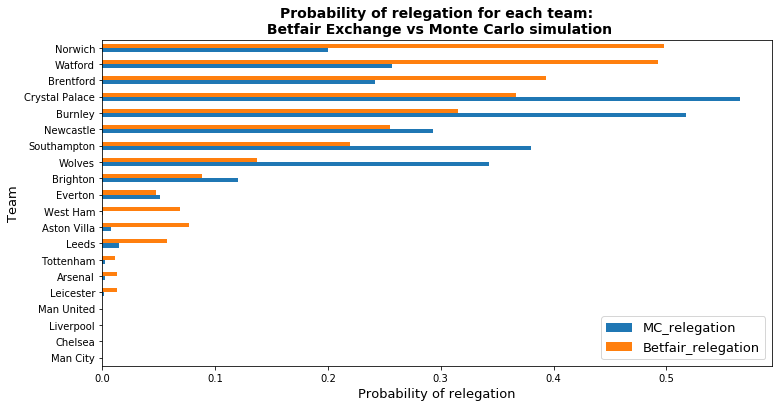

In [49]:
#isolate relegation probabilities from MC simulation and Betfair
all_prob[['MC_relegation','Betfair_relegation']].plot.barh(figsize=(12,6),width=0.5,align='center')

#configure barplot
plt.title('Probability of relegation for each team:\n Betfair Exchange vs Monte Carlo simulation',size=14,fontweight='bold')
plt.ylabel("Team",size=13)
plt.xlabel("Probability of relegation",size=13)
leg=plt.legend(loc='lower right', fontsize=13, ncol=1)

## 10 season simulation

In [50]:
from collections import Counter

n_seasons=10

#list to store league tables for each season for all iterations
ith_season_sims=[]

#will store the champions for all 10 seasons for all iterations
# number of champions=10*n_iter
champions_list=[]

#get the final league tables for each season from all the iterations into separate lists
# e.g get all the season 1 tables into one list, get all the season 2 league tables in another list etc
for i in range(0,n_seasons):
    
    #mc_res_10seasons is a nested list with each sublist containing one iteration - one iteration contains 10 league tables, one for each season
    #ith_season_sim groups the iterations by season 
    ith_season_sims=[x[i] for x in mc_res_10seasons]
    [champions_list.append(simulated_table.index[0]) for simulated_table in ith_season_sims]

#need to create a nested list so that each sublist corresponds to each season's iterations
# so first sub-list contains all season 1 iterations, second sub-list contains all season 2 iterations.. etc
nested_champions_list = [champions_list[x:x+len(mc_res_10seasons)] for x in range(0, len(champions_list),260)]

#will store the expected champion for every season (i.e most common team who wins the league for each season)
expected_champion=[]

#will store the probability of that team becoming champion
prob_exp_champion=[]


for season in nested_champions_list:
    #get the most frequent team that finishes top
    champion=Counter(season).most_common(1)[0][0]
    
    #get the probability of that team finishing top
    prob=season.count(champion)/len(season)
    
    #append results to list
    expected_champion.append(champion)
    prob_exp_champion.append(prob)
  

Text(0.5, 1.0, 'Most likely team to win the Premier League in each of the next 10 \n seasons and corresponding probability')

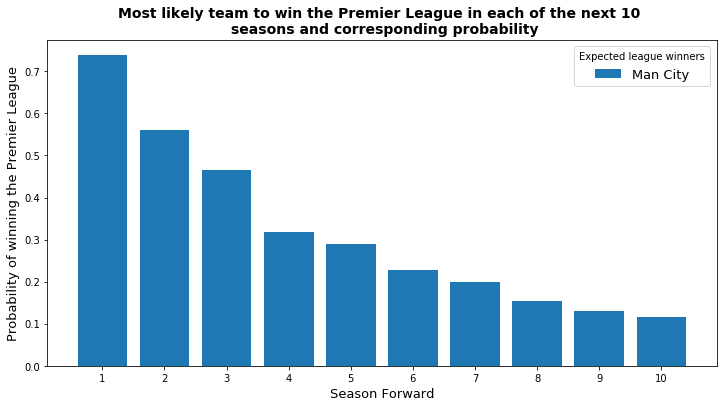

In [51]:
fig,ax = plt.subplots(figsize=(12,6))

#seasons on x axis
x=np.arange(1,n_seasons+1,1)

#probability of most likely team becoming champion on y axis
y=prob_exp_champion

#Configure bar plot
#labels are the expected champions for each season
plt.bar(x,y,label=expected_champion[0])
plt.legend(loc='best',fontsize=13,title="Expected league winners")
ax.set_xticks(x)
plt.xlabel("Season Forward",size=13)
plt.ylabel("Probability of winning the Premier League",size=13)
plt.title("Most likely team to win the Premier League in each of the next 10 \n seasons and corresponding probability",
          size=14,fontweight='bold')